In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import os

import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils

import tonic
import tonic.transforms as transforms
from tonic import DiskCachedDataset
from tonic.dataset import Dataset

import matplotlib.pyplot as plt
from IPython.display import HTML
from collections.abc import Callable

### DVS Gesture Dataset Classes

0. **Hand clapping**
1. **Right hand wave**
2. **Left hand wave**
3. **Right arm cw** (clockwise)
4. **Right arm ccw** (counter-clockwise)
5. **Left arm cw**
6. **Left arm ccw**
7. **Arm roll**
8. **Air drums**
9. **Air guitar**
10. **Other gestures**

In [2]:
sensor_size = tonic.datasets.DVSGesture.sensor_size

# 15 time steps
transform = transforms.Compose([
    transforms.ToFrame(sensor_size=sensor_size, n_time_bins=30),
])

train_set = tonic.datasets.DVSGesture(save_to='./data', train=True, transform=transform)
test_set = tonic.datasets.DVSGesture(save_to='./data', train=False, transform=transform)

# Dataloaders
cached_dataloader_args = {
    "batch_size": 64,
    "collate_fn": tonic.collation.PadTensors(batch_first=False), 
    "shuffle": True,
    "num_workers": 4,
    "pin_memory": True
}

train_loader = DataLoader(train_set, **cached_dataloader_args)
test_loader = DataLoader(test_set, **cached_dataloader_args)

data, targets = next(iter(train_loader))
print(f"Data shape: {data.shape}") 

Data shape: torch.Size([30, 64, 2, 128, 128])


In [3]:
if torch.xpu.is_available():
    device = torch.device("xpu")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Running on: {device}")

Running on: xpu


In [4]:
# Neuron parameters
beta = 0.5  
spike_grad = surrogate.atan() 

In [5]:
class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()

        # Input: 128x128 with 2 channels
        # Layer 1
        # Stride of 2 reduces dimension from 128->64
        self.conv1 = nn.Conv2d(2, 16, kernel_size=5, stride=2, padding=2) 
        self.pool1 = nn.MaxPool2d(2) # 64 -> 32
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True)

        # Layer 2
        # Stride of 2 reduces dimension from 32->16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2)
        self.pool2 = nn.MaxPool2d(2) # 16 -> 8
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True)

        # Layer 3
        # 8x8 image with 32 channels = 2048
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 8 * 8, 11) # 11 Output classes
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)

    def forward(self, x):

        x = self.conv1(x)
        x = self.pool1(x)
        x = self.lif1(x)
        
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.lif2(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        spk_out, mem_out = self.lif3(x)

        return spk_out, mem_out

net = SNN().to(device)

In [6]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-3, betas=(0.9, 0.999))
loss_fn = SF.ce_rate_loss()

In [7]:
num_epochs = 10
hist = {"loss": [], "acc": []}

print("Starting Training...")

for epoch in range(num_epochs):
    iter_loss = 0
    iter_acc = 0
    counter = 0

    net.train()
    
    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device)
        utils.reset(net) 
        spk_rec = []
        
        for step in range(data.size(0)):
            spk_out, mem_out = net(data[step])
            spk_rec.append(spk_out)


        spk_rec = torch.stack(spk_rec)
        loss_val = loss_fn(spk_rec, targets)
        acc = SF.accuracy_rate(spk_rec, targets)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        iter_loss += loss_val.item()
        iter_acc += acc
        counter += 1


    epoch_loss = iter_loss / counter
    epoch_acc = iter_acc / counter
    hist['loss'].append(epoch_loss)
    hist['acc'].append(epoch_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} \t Loss: {epoch_loss:.4f} \t Accuracy: {epoch_acc:.4f}")

Starting Training...
Epoch 1/10 	 Loss: 2.1700 	 Accuracy: 0.3067
Epoch 2/10 	 Loss: 1.8949 	 Accuracy: 0.5430
Epoch 3/10 	 Loss: 1.8452 	 Accuracy: 0.5991
Epoch 4/10 	 Loss: 1.8065 	 Accuracy: 0.6465
Epoch 5/10 	 Loss: 1.7820 	 Accuracy: 0.6620
Epoch 6/10 	 Loss: 1.7669 	 Accuracy: 0.6717
Epoch 7/10 	 Loss: 1.7470 	 Accuracy: 0.7174
Epoch 8/10 	 Loss: 1.7364 	 Accuracy: 0.7268
Epoch 9/10 	 Loss: 1.7266 	 Accuracy: 0.7404
Epoch 10/10 	 Loss: 1.7177 	 Accuracy: 0.7477


In [8]:
print("Starting Testing...")
net.eval()

total = 0
correct = 0

with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)
        
        utils.reset(net)
        spk_rec = []

        for step in range(data.size(0)):
            spk_out, mem_out = net(data[step])
            spk_rec.append(spk_out)

        spk_rec = torch.stack(spk_rec)
        
        # Calculate correct predictions
        # SF.accuracy_rate returns a ratio, so we multiply by batch size to get count
        acc = SF.accuracy_rate(spk_rec, targets)
        correct += acc * data.size(1) 
        total += data.size(1)

test_acc = correct / total
print(f"Test Accuracy: {test_acc*100:.2f}%")

Starting Testing...
Test Accuracy: 65.53%


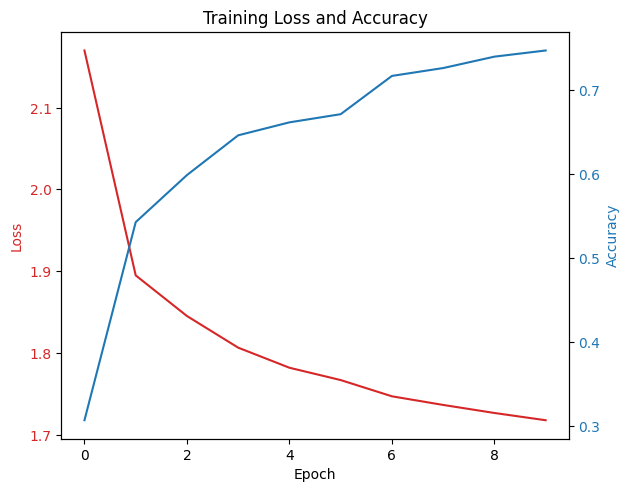

In [9]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(hist['loss'], color=color, label="Loss")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  
ax2.plot(hist['acc'], color=color, label="Accuracy")
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title("Training Loss and Accuracy")
plt.show()

In [10]:
import matplotlib.animation as animation

def play_anim(data, labels, index=0):
    """
    data: Tensor of shape (Time, Batch, Channels, Height, Width)
    labels: Target integers
    index: Which sample in the batch to visualize
    """
    
    # Select the specific sample from the batch: (Time, Channels, Height, Width)
    # We detach from graph and move to cpu for plotting
    sample = data[:, index, :, :, :].cpu()
    label_id = labels[index].item()
    class_name = train_set.classes[label_id]

    # Combine channels for visualization
    # Channel 1 (Positive) -> Red, Channel 0 (Negative) -> Blue
    # We create a single image where positive is +1 and negative is -1
    frames = sample[:, 1, :, :] - sample[:, 0, :, :]

    fig, ax = plt.subplots()
    im = ax.imshow(frames[0], cmap='seismic', vmin=-1.5, vmax=1.5)
    ax.axis('off')
    ax.set_title(f"Label: {class_name}")

    def update(frame_idx):
        # Update the image data for the next frame
        im.set_data(frames[frame_idx])
        return [im]

    # Create animation
    # frames=sample.shape[0] ensures we loop through all 15 time steps
    ani = animation.FuncAnimation(fig, update, frames=sample.shape[0], interval=200, blit=True)
    
    plt.close() # Prevent static plot from showing up separately
    return ani

In [11]:
# 1. Get a batch of data
data_batch, targets_batch = next(iter(test_loader))

# 2. Generate the animation for the first sample in the batch (index 0)
anim = play_anim(data_batch, targets_batch, index=0)

# 3. Render it in the notebook
HTML(anim.to_jshtml())

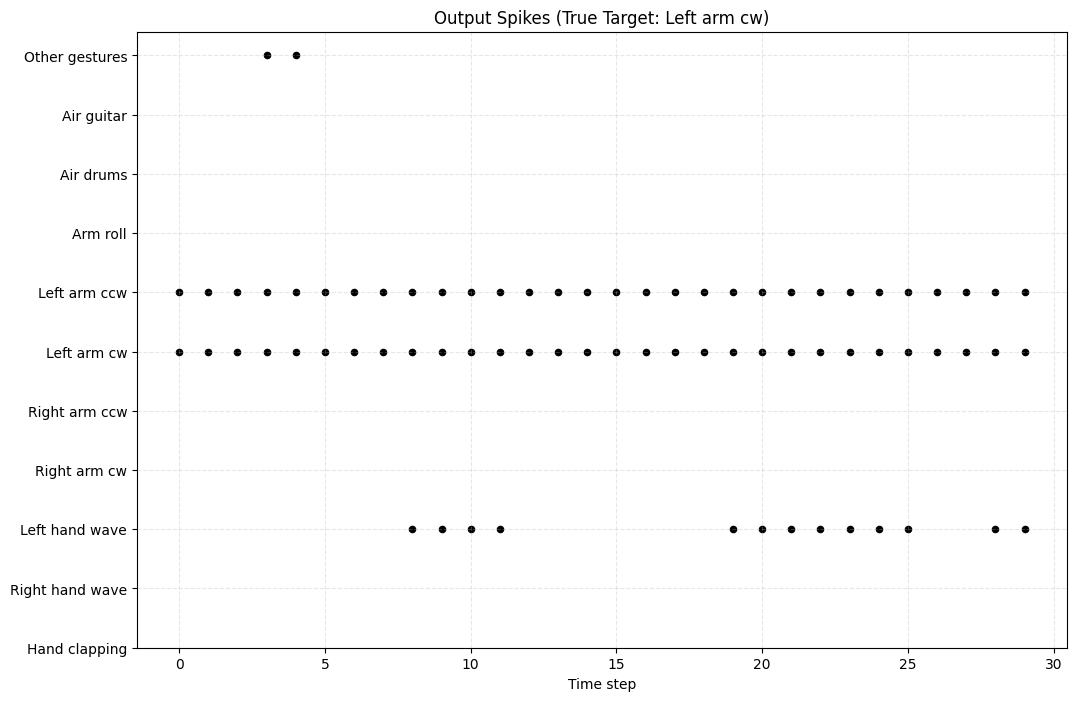

In [12]:
import snntorch.spikeplot as splt
import matplotlib.pyplot as plt

data, targets = next(iter(test_loader))
data = data.to(device)
targets = targets.to(device)

net.eval()
utils.reset(net)
spk_rec = []

for step in range(data.size(0)):
    spk_out, mem_out = net(data[step])
    spk_rec.append(spk_out)

spk_rec = torch.stack(spk_rec)

idx = 0 
fig, ax = plt.subplots(facecolor='w', figsize=(12, 8))

# Plot the spikes
splt.raster(spk_rec[:, idx, :], ax, s=20, c="black")


class_labels = train_set.classes
ax.set_yticks(range(len(class_labels)))
ax.set_yticklabels(class_labels)


plt.title(f"Output Spikes (True Target: {class_labels[targets[idx]]})")
plt.xlabel("Time step")
plt.grid(True, linestyle='--', alpha=0.3) 
plt.show()